In [ ]:
# import 정리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import warnings
warnings.simplefilter('ignore') 
warnings.filterwarnings('ignore')
from scipy.stats import norm, t
import scipy as sp
from pylab import rcParams
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats

import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 1. 문제 정의

### 목적
- 2022년 인도 전역에서의 렌트 하우스의 속성을 통해 렌트 비용을 예측한다.
- Regression 문제

### 활용 데이터 및 방법론
- 활용 데이터
    1. 캐글 House Rent Prediction Dataset  :https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset

In [ ]:
df = pd.read_csv('House_Rent_Dataset.csv')
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


- 캐글 데이터셋
    - 입력 변수
        - Posted On : 렌트 날짜
        - BHK : 침실, 거실, 부엌 수
        - Size: 렌트 하우스 크기(단위 : sqft)
        - Floor: 렌트 하우스 층수
        - Area Type: 렌트 하우스 크기 측정 기준
          - Carpet Area : 내벽 두께를 제외한 면적
          - Build Area: 내벽 두께를 포함한 건물 전체 면적
          - Super Area: Build Area + 공용면적(계단, 로비, 승강기, 수영장 등)
        - Area Locality: 렌트 하우스 주소
        - City: 렌트 하우스가 위치한 도시
        - Furnishing Status: 가구 옵션
        - Tenant Preferred: 집주인이 원하는 입주자의 상태
        - Bathroom: 화장실 수
        - Point of Contact: 문의 받는 사람
    - 타겟 변수
        - Rent: 렌트 하우스 임대료

## 2. 데이터 준비

### 데이터 딕셔너리(Data Dictionary)

| Variable | Definition   | Type |
| :-: | :-: | :-: |
| Posted On | 임대 게시일   | Categorical |
| BHK |   침실,거실,부엌 수   | Numeric(Continuous) |
| Rent |   렌트 하우스 임대료   | Numeric(Continuous) |
| Size | 렌트 하우스 크기(sqft) | Numeric(Continuous) |
| Floor | 렌트 하우스 층수 | Categorical |
| Area Type |   렌트 하우스 크기 측정 기준 | Categorical(Numerical(Carpet Area: 0 Build Area: 1 Super Area: 2)) |
| Area Locality    |   렌트 하우스 주소   | Categorical |
| City | 렌트 하우스가 위치한 도시 | Categorical |
| Furnishing Status | 가구 옵션 | Categorical(Numerical(Furnished: 0 Semi-Furnished: 1 UnFurnished: 2)) |
| Tenant Preferred    | 집주인이 원하는 입주자의 상태 | Categorical(Numerical(Bachelors: 0 Family: 1 Bachelors/Family: 2)) |
| Bathroom | 화장실 수 | Numeric(Continuous) |
| Point of Contact |   문의 받는 사람   | Categorical(Numerical(Contact Owner: 0 Contact Agent: 1)) |

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [ ]:
df.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [ ]:
df.describe(include='object')

,Posted On,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Point of Contact
count,4746,4746,4746,4746,4746,4746,4746,4746
unique,81,480,3,2235,6,3,3,3
top,2022-07-06,1 out of 2,Super Area,Bandra West,Mumbai,Semi-Furnished,Bachelors/Family,Contact Owner
freq,311,379,2446,37,972,2251,3444,3216


In [ ]:
df['Area Type'].value_counts()

Super Area     2446
Carpet Area    2298
Built Area        2
Name: Area Type, dtype: int64

In [ ]:
df['City'].value_counts()

Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
Name: City, dtype: int64

- 수치/범주형 데이터 분리
    - Target 값('Rent')분리

In [ ]:
category_feature = [ col for col in df.columns if df[col].dtypes == "object"]
numerical_features = list(set(df.columns) - set(category_feature) - set(['Rent']))
corr_features =  list(set(df.columns) - set(category_feature))
numerical_features = np.sort(numerical_features)
print(numerical_features)
print(category_feature)

['BHK' 'Bathroom' 'Size']
['Posted On', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


## 3. 변수 분석


### Target 변수 분석 
-  렌트값 기술통계

In [ ]:
target = df['Rent']
target.describe()

count    4.746000e+03
mean     3.499345e+04
std      7.810641e+04
min      1.200000e+03
25%      1.000000e+04
50%      1.600000e+04
75%      3.300000e+04
max      3.500000e+06
Name: Rent, dtype: float64

<AxesSubplot:xlabel='Rent', ylabel='Density'>

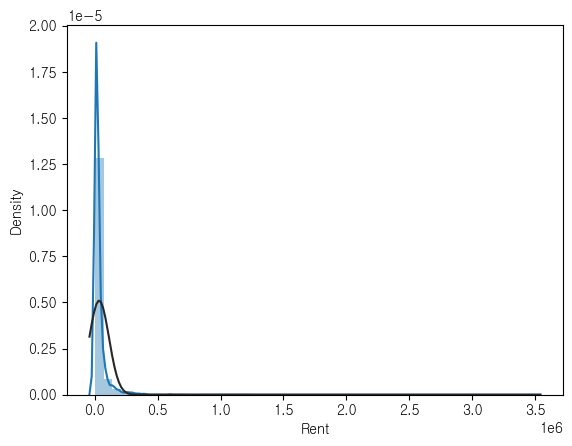

In [ ]:
sns.distplot(target, fit=sp.stats.norm)

In [ ]:
# 왜도
skew = target.skew()
# 첨도
kurt = target.kurtosis()
print('Value - 왜도: {0}, 첨도: {1}'.format(skew, kurt))

Value - 왜도: 21.409942283288803, 첨도: 841.1080672214921


- skewness가 -1보다 작거나 1보다 클 경우 데이터는 상당히 치우쳐있다고 볼 수 있음
- Kurtosis > 3 : 분포가 길고, 꼬리가 더 뚱뚱하다.  데이터의 이상치(outlier)가 높다고 볼 수 있음

- 렌트값의 편차가 굉장히 큼
    - 이상치가 평균과 분산에 지장을 매우 많이 주고 있으므로 minmax_scale과 standard_scale을 쓰는 것은 적합하지 않을 것으로 판단
    - log_scale을 쓰기 전 displot을 통해 왜도와 첨도를 알아본다
    - 왜도: 실수 값 확률 변수의 확률 분포 비대칭성을 나타내는 지표
    - 첨도 :확률분포의 꼬리가 두꺼운 정도를 나타내는 척도이다. 극단적인 편차 또는 이상치가 많을 수록 큰 값을 나타낸다

- 표본분포는 모집단분포와 비교
    - 왜도: 현재 Rent 값의 표본분포 모집단 분포와 비교시 Positive Skewness를 띄고 있다.
        - Positive Skewness => log변환을 통해 처리 가능
    - 첨도: 현재 Rent 값의 표본분포는 모집단분포에 비해 첨도가 높음
        - 첨도가 높으므로 이상치가 많이 있다고 판단 가능

In [ ]:
m = target.mean()
s = target.std()
sigma = np.sqrt(s)
dof = len(target)-1
confidence = 0.95
#confidence = 0.99


z_crit = np.abs(norm.ppf((1-confidence)/2))
t_crit = np.abs(t.ppf((1-confidence)/2, dof))
z_interval_st = stats.t.interval(0.95, len(target)-1, loc=np.mean(target), scale=stats.sem(target))
z_interval = (m-sigma*z_crit/np.sqrt(len(target)), m+sigma*z_crit/np.sqrt(len(target)))
print('z_crit:', z_crit)
print('t_crit:', t_crit)
print(z_interval, z_interval_st)

z_crit: 1.959963984540054
t_crit: 1.9604640617118576
(34985.500220932554, 35001.4024339347) (32770.74691506008, 37216.155739807175)


- 본 팀은 문제 해결 방법으로 주어져 있는 인도 렌트 하우스의 분포의 모평균을 구하고자 함
    - 모집단 평균의 구간 추정을 하기 위해 z검정을 사용 한다(모분산을 알고 있기 때문)
        - z 검정: 귀무 가설하에서 테스트(검정) 통계량의 분포를 정규 분포로 근사할 수 있는 기초적인 추론 통계 검정


- confidence = 0.95일때 해당 target은 양측검정이다
    - z검정의 임계값은 1.959963984540054 이다
    - z_interval은 34986 ~ 35001 사이이다(scipy(32770.74691506008, 37216.155739807175))
    - z_interval 범위 외의 값은 이상치로 간주하고 제거 할 수도 있다
    - 단, 머신러닝 모델을 적용 할 경우에는 원래 데이터에서 Scaling으로 log_scaling을 적용한 데이터를 적용 해볼 것이다
    - 제조 데이터와는 달리 인도의 집값 예측에서 해당 이상치들이 마냥 이상치로 볼 수는 없기 때문임

#### Log Scaling

- 분석을 진행할때 log scale의 Rent도 target으로 시도하는 것도 의미 있을 듯 함
- log scale 임에도 불구하고 이상치가 있음. log scale 기준 10~18까지 데이터만 사용
    - log scaling을 취하는 이유: standard scaler와 Nomalization은 이상치에 영향을 많이 받기 때문에

<AxesSubplot:xlabel='Rent', ylabel='Density'>

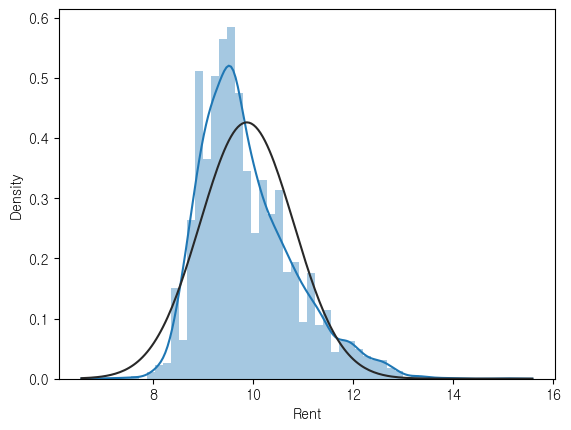

In [ ]:
sns.distplot(np.log(target), fit=sp.stats.norm)

### 명목형 변수 분석

In [ ]:
category_feature = [ col for col in df.columns if df[col].dtypes == "object"]
categorical_feature = list(set(category_feature))
category_feature

['Posted On',
 'Floor',
 'Area Type',
 'Area Locality',
 'City',
 'Furnishing Status',
 'Tenant Preferred',
 'Point of Contact']

#### Floor 변수 분석

1. 데이터 분포
    - 렌트 하우스 층수

In [ ]:
# Floor column은 전체 건물의 층수와 임대할 건물의 층으로 구성이 되어 있는데, 이 형식을 따르지 않는 데이터 추출
booling_result = []
False_index = []
for i in range(len(df)):
    if df["Floor"][i].find(" out of ") != -1:
        continue
    else:
        False_index.append(i)

df.loc[False_index]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2553,2022-06-18,2,20000,400,3,Super Area,"Kasturba Niketan, Lajpat Nagar 2",Delhi,Unfurnished,Bachelors/Family,1,Contact Owner
2883,2022-05-23,1,18000,450,Ground,Carpet Area,"DDA Flat AD Block, Shalimar Bagh AD Block",Delhi,Furnished,Bachelors/Family,1,Contact Owner
4490,2022-06-12,3,15000,900,1,Super Area,"Malakpet, NH 9",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4560,2022-05-31,3,15000,1270,1,Carpet Area,Tarnaka,Hyderabad,Furnished,Family,2,Contact Owner


In [ ]:
df.drop(index = False_index, axis = 0, inplace = True)
df = df.reset_index(drop=True)

floor_of_building = []
floor = []

for i in range(len(df)):
    split_str = df["Floor"][i].split(" out of ")
    if split_str[0] == "Ground":
        floor.append(0)
    elif split_str[0] == "Upper Basement":
        floor.append(0.5)
    elif split_str[0] == "Lower Basement":
        floor.append(-1)
    else:
        floor.append(int(split_str[0]))
    floor_of_building.append(int(split_str[1]))

df["Floor"] = floor
df["Floor Of Building"] = floor_of_building

In [ ]:
fig = px.scatter(df,
                 x='Floor',
                 y='Rent',
                 color='Floor')
fig.show()

- 전처리 결과
    1. 데이터 분포
        - 데이터 분포만 확인 했을 경우 Floor가 올라간다 해서 Rent가 올라갈 것이라고 판단하기 힘듦
    2.  이상치
        - Floor: 4 , Rent 350만 루피

#### Posted On 변수 분석

In [ ]:
month = []
for i in range(len(df)):
    month.append(df["Posted On"][i][5:7])

df["Month"] = month

df.drop(columns = ["Posted On"], axis = 1, inplace = True)
print(df["Month"].value_counts().sort_values())

fig = px.scatter(df,
                 x='Month',
                 y='Rent',
                 color='Month')
fig.show()
df.drop(columns = ["Month"], axis = 1, inplace = True)

04     228
07     978
05    1679
06    1857
Name: Month, dtype: int64


- 전처리 결과
    1. 데이터 분포
        - 4월(21일)과 7월(19일)의 데이터에 거래가 없는 곳이 있음
        - 6월에 거래량이 제일 많고 4월에 거래량이 제일 적음
        - 해당 거래 내역이 정말로 거래가 없었는지, 데이터 수집이 되지 않았던 것인지 찾아보았으나 확인 불가
        - Month의 경우 데이터의 신뢰성이 떨어지기 때문에 변수를 제거
    2.  이상치
        - 4월, Rent 350만 루피가 거래됨


#### City 변수 분석

In [ ]:
fig = px.scatter(df,
                 x='City',
                 y='Rent',
                 color='City')
fig.show()

In [ ]:
filt = df["Rent"] >= 3000000
df[filt]
filt = df["Size"] >= 2500
for_graph = df[filt]

# 다변량 분석 : Size, Floor, City 변수를 Rent에 비교
fig = px.scatter(for_graph,
                 x = 'Size',
                 y = 'Rent',
                 size = 'Floor Of Building',
                 color = "City")
fig.show()

df.drop(index = 1837, axis = 0, inplace = True)
df = df.reset_index(drop=True)

- 독립성 검정
    1. Point biserial correlation
        -  X변수가 연속형이고, Y변수는 이분변수일 때 사용하는 상관계수이다
        - 이분변수는 네/아니오, 있음/없음 등의 형태를 말하고 이를 0과 1로 코딩한 다음 pearson 상관계수를 계산한 것
    2. One-hot encoding을 시행하여 변수와 Rent의 상관관계 파악

In [ ]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(df[["City"]])
one_hot_encoded = ohe.transform(df[["City"]])
ohe_df = pd.DataFrame(one_hot_encoded, columns = ohe.categories_[0])
df_one = pd.concat([df, ohe_df], axis = 1)
df_one.drop(columns = ["City"], axis = 1, inplace = True)

In [ ]:
target = df['Rent']
City_list=['Mumbai', 'Kolkata', 'Hyderabad', 'Delhi', 'Chennai', 'Bangalore']

for i in City_list:
    point = stats.pointbiserialr(df_one[i], target)
    print('도시', i, '와 임대료 상관분석\n', point)

도시 Mumbai 와 임대료 상관분석
 PointbiserialrResult(correlation=0.43368225607820654, pvalue=1.0417159750205455e-216)
도시 Kolkata 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.1334780927610851, pvalue=2.718332395158687e-20)
도시 Hyderabad 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.1084348651161312, pvalue=7.079491541335361e-14)
도시 Delhi 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.030535286304506633, pvalue=0.03551470586825382)
도시 Chennai 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.1019248678015068, pvalue=1.9997132007244866e-12)
도시 Bangalore 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.10610532390730323, pvalue=2.395562925971114e-13)


- 전처리 결과
    1. 데이터 분포
        - 4월(21일)과 7월(19일)의 데이터에 거래가 없는 곳이 있음
        - 6월에 거래량이 제일 많고 4월에 거래량이 제일 적음
        - 해당 거래 내역이 정말로 거래가 없었는지, 데이터 수집이 되지 않았던 것인지 찾아보았으나 확인 불가
        - Month의 경우 데이터의 신뢰성이 떨어지기 때문에 변수를 제거
    2. 독립성 검정
        - P_value가 0에 가까우므로 City와 Rent는 상관관계를 가진다고 볼 수 있음
    3.  이상치 제거
        - Bangalore에서 350만 루피의 거래가 발생함
        - City, Posted on, Floor에서 동시에 나타나는 데이터 값은 데이터 원본을 탐색한 결과 정상적인 거래라고 판단 할 수 없었음
        - 해당 데이터 삭제

#### Arealocality 변수 분석

In [ ]:
df.drop(columns = ["Area Locality"], axis = 1, inplace = True)

- 전처리 결과
    - Arealocality는 세부 주소를 나타내고 개수가 매우 많음
    - one - hot encoding도 불가능 하다고 판단했기 때문에 삭제

#### Point of Contact 변수 분석

In [ ]:
df['Point of Contact'].value_counts()

Contact Owner      3212
Contact Agent      1528
Contact Builder       1
Name: Point of Contact, dtype: int64

In [ ]:
fig = px.scatter(df,
                 x='Point of Contact',
                 y='Rent',
                 color='City')
fig.show()


In [ ]:
ct = pd.crosstab(df['Point of Contact'], df['City'])

chi2, pval, dof, expected = stats.chi2_contingency(ct)
print('chi2:', round(chi2, 4))
print('p-value:', round(pval, 4)) # p-value가 a보다 작으므로 기각
print('Expected: \n', expected)

chi2: 1442.7543
p-value: 0.0
Expected: 
 [[2.85230964e+02 2.87164733e+02 1.94343809e+02 2.79107361e+02
  1.68882514e+02 3.13270618e+02]
 [1.86669479e-01 1.87935035e-01 1.27188357e-01 1.82661886e-01
  1.10525206e-01 2.05020038e-01]
 [5.99582367e+02 6.03647332e+02 4.08529002e+02 5.86709977e+02
  3.55006961e+02 6.58524362e+02]]


In [ ]:
df.drop(columns = ["Point of Contact"], axis = 1, inplace = True)

- 전처리 결과
    1. 데이터 분포
        - Contact Builder는 전체4700여개 데이터중 단 2개만 존재함
        - 그래프를 보았을 때 Contact Agent와, Contact Owner가 상관관계가 있다고 보기 힘듦
        
    2. 상관관계 분석
        - Point of Contact 변수의 경우 데이터 분포를 보았을 때 Contact Agent에 Mumbai가 눈에 띄게 높다
        - 상관관계 분석결과 데이터에 있어 Point of Contact가 City와 강한 상관관계를 가진다
        - 회귀분석 시행시 두 변수가 함께 있을 경우 모델의 과적합이 발생할 가능성이 높으므로 Point of Contract 변수를 삭제한다


#### Area Type 분석

In [ ]:
df['Area Type'].value_counts()

Super Area     2444
Carpet Area    2295
Built Area        2
Name: Area Type, dtype: int64

In [ ]:
fig = px.scatter(df,
                 x='Area Type',
                 y='Rent',
                 color='Area Type')
fig.show()


In [ ]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(df[["Area Type"]])
one_hot_encoded = ohe.transform(df[["Area Type"]])
ohe_df = pd.DataFrame(one_hot_encoded, columns = ohe.categories_[0])
df_one = pd.concat([df, ohe_df], axis = 1)
df_one.drop(columns = ["Area Type"], axis = 1, inplace = True)

target = df['Rent']
var_list=['Carpet Area','Super Area','Built Area']

for i in var_list:
    point = stats.pointbiserialr(df_one[i], target)
    print( i, '와 임대료 상관분석\n', point)

Carpet Area 와 임대료 상관분석
 PointbiserialrResult(correlation=0.269621350360447, pvalue=9.233505953634264e-80)
Super Area 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.269278393285295, pvalue=1.482505071494423e-79)
Built Area 와 임대료 상관분석
 PointbiserialrResult(correlation=-0.008172492577054416, pvalue=0.5737227300855906)


In [ ]:
filt = df["Area Type"] == "Built Area"
df[filt]

df.drop(index = [3076, 3963], axis = 0, inplace = True)

df = df.reset_index(drop=True)

- 전처리 결과
    1. 데이터 분포
        - Contact Builder는 전체4700여개 데이터중 단 2개만 존재함 => 분석에 오히려 방해가 될 수 있으므로 삭제하겠음
    2. 독립성 검정
        - P_value가 0에 가까우므로 Point of Contact와 Rent는 상관관계를 가진다고 볼 수 있음
        - Built Area의 경우 유의수준 0.95를 가정했을 때 p-value가 0.5기 때문에 상관관계가 없다는 가설을 채택한다
        - Built Area 삭제

#### 그 외 변수 분석
1. 데이터 분포 파악
2. One-hot encoding 적용

In [ ]:
# need_encoding_columns = ["Area Type","City", "Furnishing Status", "Tenant Preferred"]
# for i in need_encoding_columns :
#     plt.figure(figsize=(10,5))
#     box=sns.boxplot(x=f'{i}',y='Rent',data=df)
#     box.set_title(i)
#     plt.show()

In [ ]:
need_encoding_columns = ["Area Type", "City" ,"Furnishing Status", "Tenant Preferred"]
for i in need_encoding_columns:
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(df[[i]])
    one_hot_encoded = ohe.transform(df[[i]])
    ohe_df = pd.DataFrame(one_hot_encoded, columns = ohe.categories_[0])
    df = pd.concat([df, ohe_df], axis = 1)
    df.drop(columns = [i], axis = 1, inplace = True)

### 연속형 변수 분석

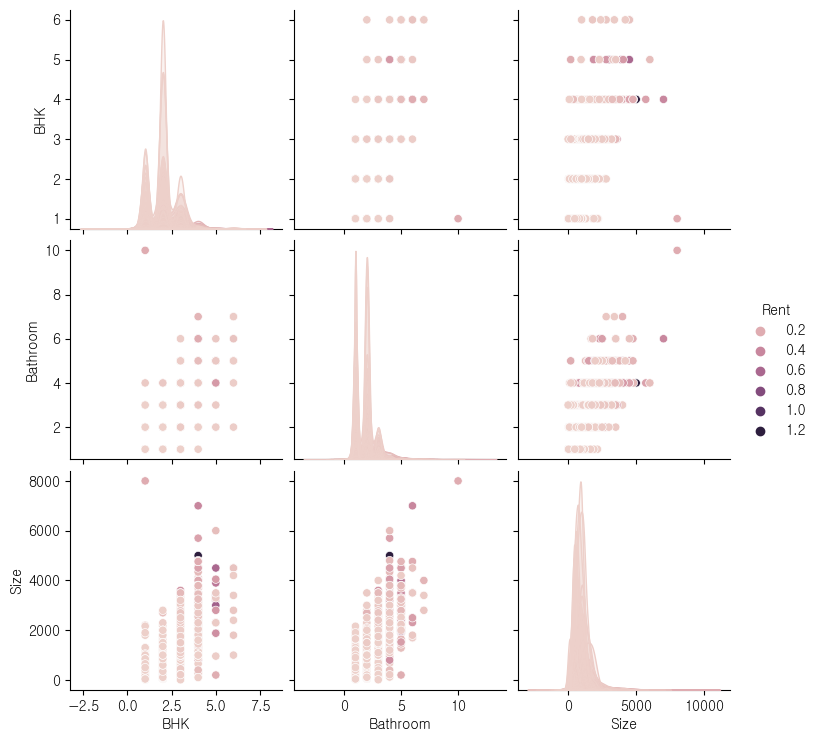

In [ ]:
sns.pairplot(df[list(numerical_features) + ['Rent']], hue='Rent', x_vars=numerical_features, y_vars=numerical_features)
plt.show()

#### 상관계수 유의성 검정
- 귀무가설 : Size와 Rent는 상관관계가 없을 것이다
- 상관관계 분석
    - 연속형 변수를 피어슨 상관계수를 통해 분석한다

In [ ]:
for i in numerical_features:
    r, pval = stats.pearsonr(df[f'{i}'], df.Rent)
    print(i,'r:', round(r, 2),'p-value:',round(pval,4))


BHK r: 0.47 p-value: 0.0
Bathroom r: 0.56 p-value: 0.0
Size r: 0.51 p-value: 0.0


- p-value가 0에 가까우므로 유의수준 a = 0.05의 귀무가설 하에서 귀무가설을 기각할 수 없다
    - 유의수준 0.05 보다 p-value가 크므로 두 변수간 상관관계가 없다는 가설을 기각

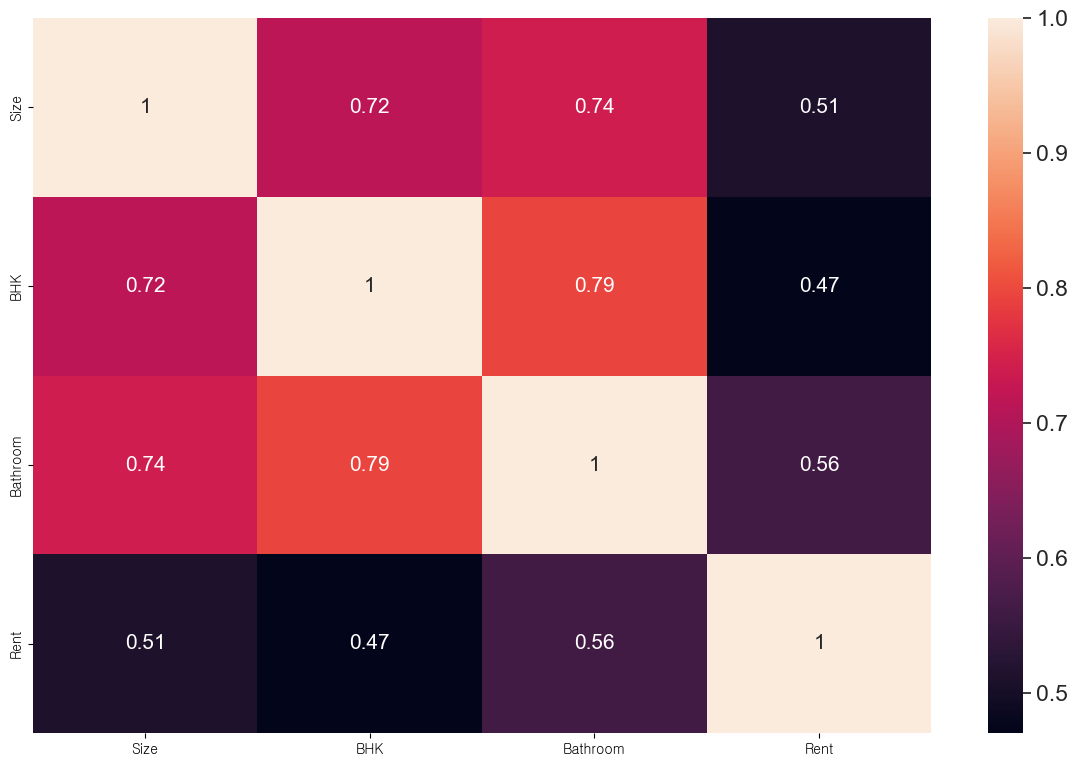

In [ ]:
corr_features = ['Size', 'BHK', 'Bathroom', 'Rent']
cols = corr_features
corr = df[cols].corr(method = 'pearson') 

fig = plt.figure(figsize=(12,8))
ax = fig.gca()  

sns.set(font_scale=1.5) 
hm = sns.heatmap(corr.values,
                 annot=True, 
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols,
                 ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()

corr_ss = scaler.fit_transform(df[corr_features])

for i in range(len(corr_ss)):
    df["Size"][i] = corr_ss[i][0]
    df["BHK"][i] = corr_ss[i][1]
    df["Bathroom"][i] = corr_ss[i][2]

In [ ]:
df.head()

,BHK,Rent,Size,Floor,Bathroom,Floor Of Building,Carpet Area,Super Area,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family
0,-0.100669,10000,0.209067,0.0,0.03841,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.100669,20000,-0.264073,1.0,-1.09217,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.100669,17000,0.051354,1.0,-1.09217,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.100669,10000,-0.264073,1.0,-1.09217,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.100669,7500,-0.185216,1.0,-1.09217,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 모델 적용

- 전처리한 데이터를 머신러닝 모델에 적용하여 문제 해결

In [ ]:
def get_result(y_trn, y_pred):
    mse = mean_squared_error(y_trn, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_trn, y_pred)

    print('MSE: %.2f, \nRMSE: %.2f, \nMAE: %.2f' % (mse, rmse, mae))
    result = pd.DataFrame({'Actual': y_trn.values.reshape(-1), 'Predicted': y_pred.reshape(-1)})
    sns.regplot(x='Actual', y='Predicted', data=result)
    plt.plot(np.arange(np.ceil(result.max().max())), np.arange(np.ceil(result.max().max())), 'r')
    plt.show()

#### Target 변수에 스케일링 하지 않고 모델 적용

MSE: 1662560995.01, 
RMSE: 40774.51, 
MAE: 20986.22


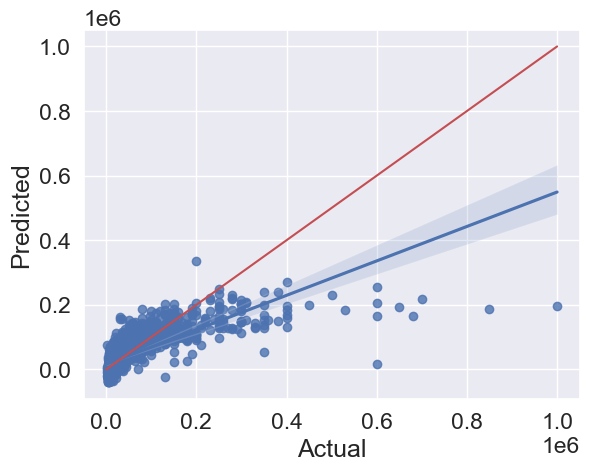

MSE: 143658205.13, 
RMSE: 11985.75, 
MAE: 4617.66


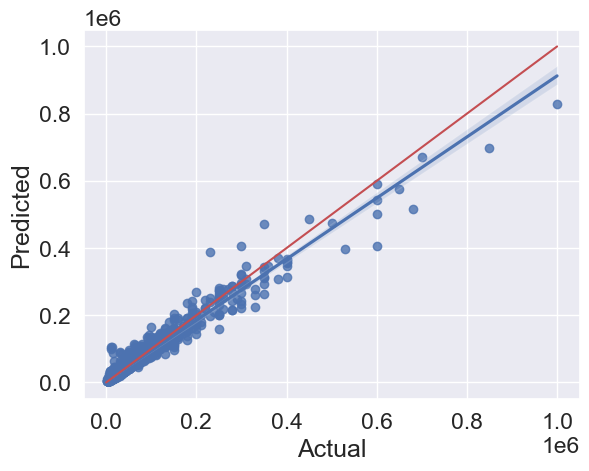

MSE: 1069442.43, 
RMSE: 1034.14, 
MAE: 213.70


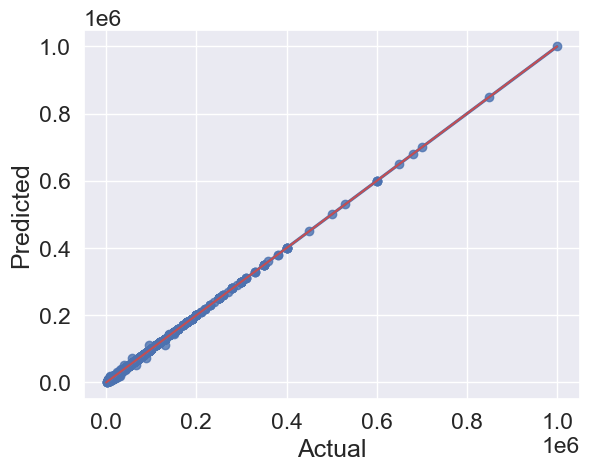

MSE: 464928533.58, 
RMSE: 21562.20, 
MAE: 8838.34


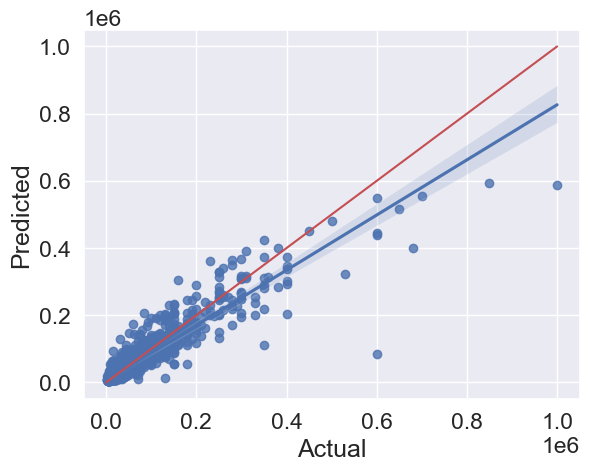

MSE: 540746830.16, 
RMSE: 23253.96, 
MAE: 10165.88


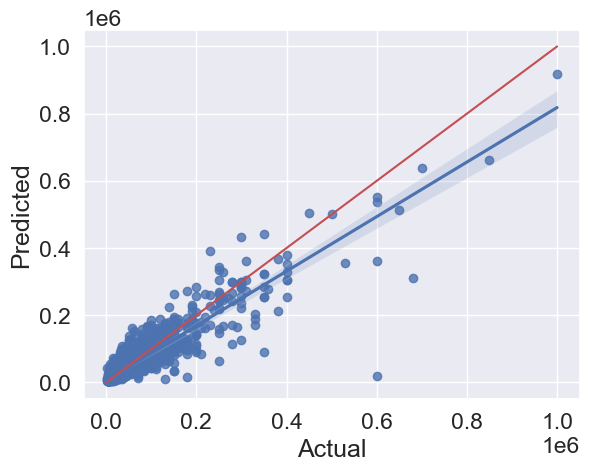

In [ ]:
X=df.drop('Rent', axis=1)
y=df['Rent']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model_lr = LinearRegression()
model_rb = RandomForestRegressor()
model_dt = DecisionTreeRegressor()
model_lgbm = LGBMRegressor()
model_gb=GradientBoostingRegressor()


model_lr.fit(X_train, y_train)
model_rb.fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_lgbm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)


y_train_pred = model_lr.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_rb.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_dt.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_lgbm.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_gb.predict(X_train)
get_result(y_train, y_train_pred)


In [ ]:
coeff = pd.Series(data=np.round(model_lr.coef_[0], 4), index=df[corr_features].columns)
print(coeff)

Size        2553.3143
BHK         2553.3143
Bathroom    2553.3143
Rent        2553.3143
dtype: float64


#### 로그 스케일을 취한 모델 분석


MSE: 0.17, 
RMSE: 0.42, 
MAE: 0.31


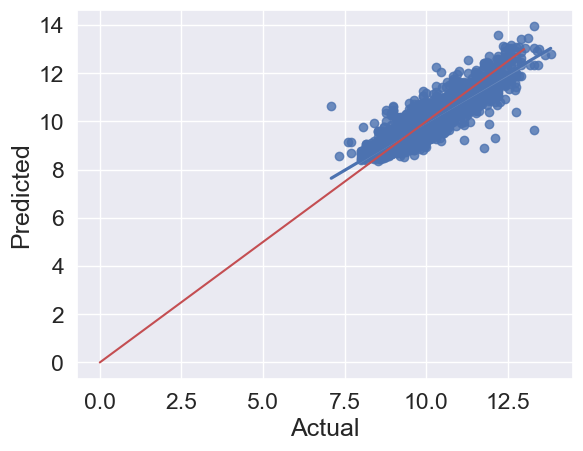

MSE: 0.03, 
RMSE: 0.17, 
MAE: 0.12


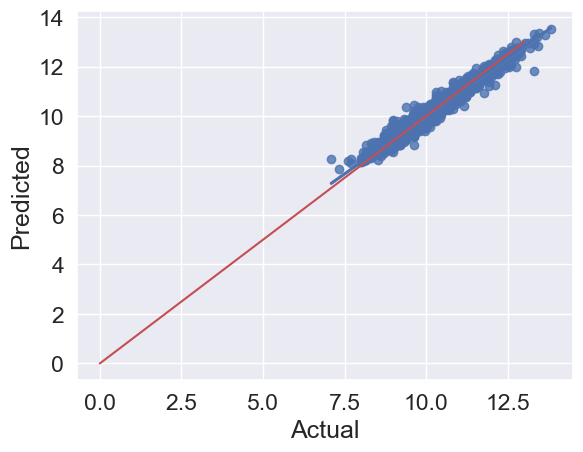

MSE: 0.00, 
RMSE: 0.07, 
MAE: 0.02


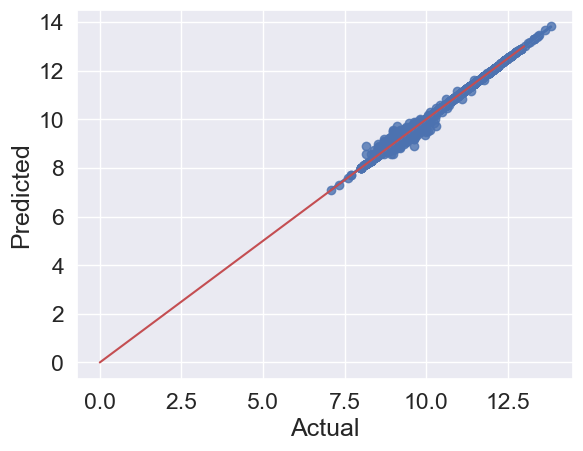

MSE: 0.10, 
RMSE: 0.31, 
MAE: 0.23


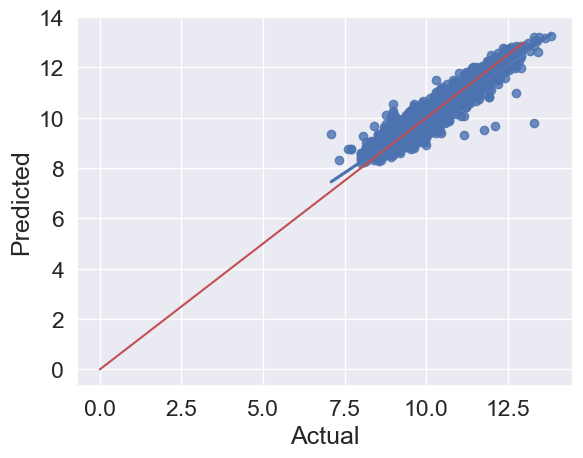

MSE: 0.14, 
RMSE: 0.37, 
MAE: 0.28


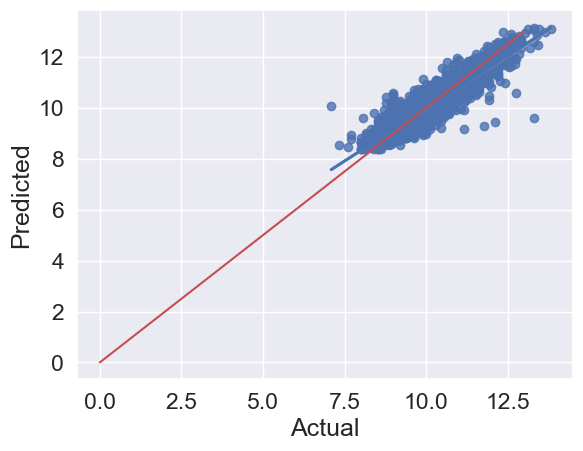

In [ ]:
X=df.drop('Rent', axis=1)
y=df['Rent']

y_log = np.log1p(y)

X_train,X_test,y_train,y_test=train_test_split(X,y_log,test_size=0.2,random_state=42)



model_lr = LinearRegression()
model_rb = RandomForestRegressor()
model_dt = DecisionTreeRegressor()
model_lgbm = LGBMRegressor()
model_gb= GradientBoostingRegressor()


model_lr.fit(X_train, y_train)
model_rb .fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_lgbm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)


y_train_pred = model_lr.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_rb.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_dt.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_lgbm.predict(X_train)
get_result(y_train, y_train_pred)

y_train_pred = model_gb.predict(X_train)
get_result(y_train, y_train_pred)


In [ ]:
coeff = pd.Series(data=np.round(model_lr.coef_[0], 4), index=df[corr_features].columns)
print(coeff)

Size        0.179
BHK         0.179
Bathroom    0.179
Rent        0.179
dtype: float64


MSE: 0.16, 
RMSE: 0.40, 
MAE: 0.31


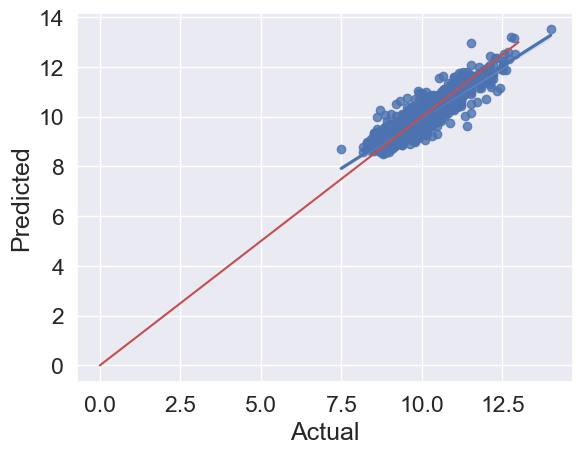

MSE: 0.16, 
RMSE: 0.40, 
MAE: 0.31


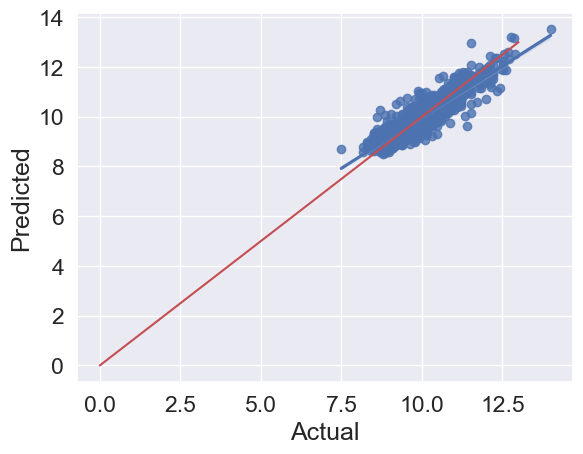

MSE: 0.16, 
RMSE: 0.40, 
MAE: 0.31


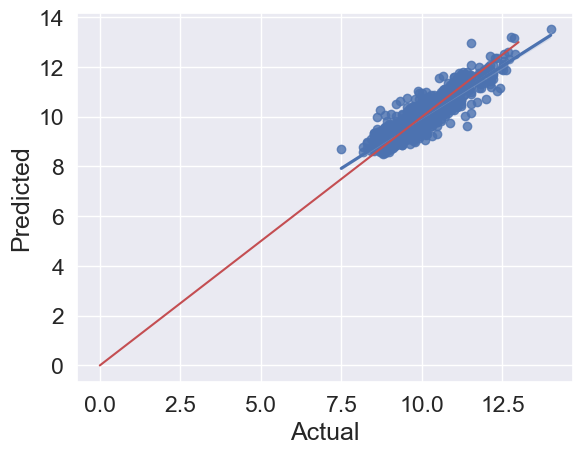

MSE: 0.16, 
RMSE: 0.40, 
MAE: 0.31


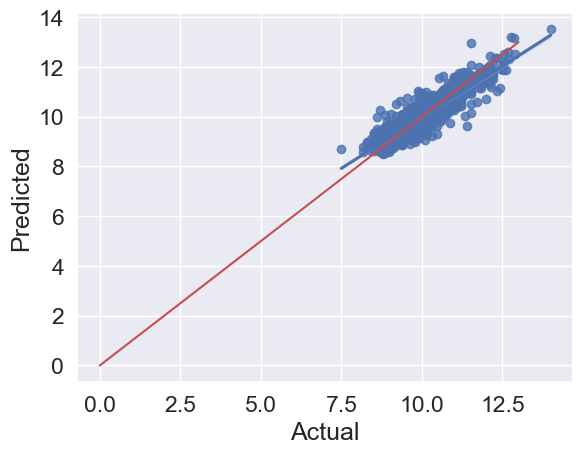

MSE: 0.16, 
RMSE: 0.40, 
MAE: 0.31


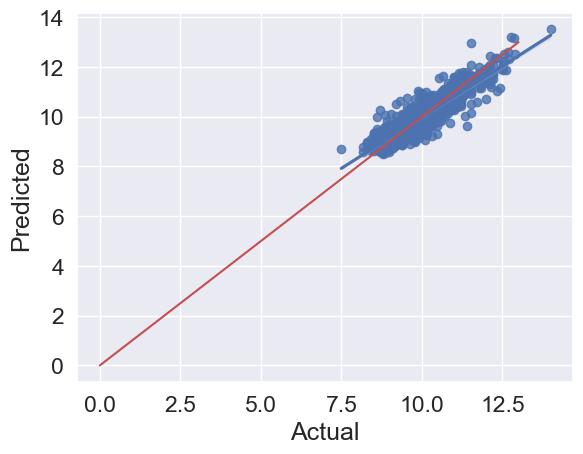

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_rb = model_lr.predict(X_test)
y_pred_dt= model_lr.predict(X_test)
y_pred_lgbm = model_lr.predict(X_test)
y_pred_gb = model_lr.predict(X_test)

get_result(y_test,y_pred_lr)
get_result(y_test,y_pred_rb)
get_result(y_test,y_pred_dt)
get_result(y_test,y_pred_lgbm)
get_result(y_test,y_pred_gb)


### 역할 분담
1. 최인수 : 총괄, 데이터 시각화
2. 조현건 : 가설검정, 통계분석
3. 윤기창 : 모델링, 데이터 전처리